In [6]:
import numpy as np 
import pandas as pd 
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans


In [7]:
events = pd.read_csv('../store/data/sampled_events.csv')
products = pd.read_csv('../store/data/sampled_products.csv')
users = pd.read_csv('../store/data/sampled_users.csv')

In [8]:
# data merge
df_product_events = events.merge(products,on=['item_no'],how='outer')
df = df_product_events.merge(users,on=['user_no'],how='outer')

In [9]:
# column 정렬
key_cols = df.columns.to_list()
target_cols = key_cols  
target_cols.remove('device_type')
target_cols.remove('mobile_brand_name')
target_cols.remove('mobile_model_name')
target_cols.remove('mobile_marketing_name')
target_cols.remove('operating_system_version')
target_cols.remove('birth_date')

df = df[target_cols]

In [10]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])

# Cohort Analysis

In [11]:
df['OrderCycle'] = df['event_timestamp'].dt.weekofyear
df.head()

/var/folders/4m/m7wqswhn18s7cwjypkmlymcc0000gn/T/ipykernel_34751/2377641024.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['OrderCycle'] = df['event_timestamp'].dt.weekofyear


,session_id,event_timestamp,event_name,user_no,item_no,country,region,platform,item_name,image_name,...,category1_code,category1_name,category2_code,category2_name,category3_code,category3_name,brand_no,brand_name,gender,OrderCycle
0,c47e93742387750baba2e238558fa12d,2021-06-03 13:00:01.845000,click_item,+9eODQMZ8YgXQZJJAo56nw==,4KwsZkXDulM0oQ2sTVSlYQ==,South Korea,Gyeonggi-do,ANDROID,남성) 코튼 리넨 이지 쇼츠,ecb06f34b6d8c4c521221aebbcc0e934,...,243100100,의류,243104100,하의,243104101,바지,13901.0,TOPTEN,F,22
1,c47e93742387750baba2e238558fa12d,2021-06-03 13:00:47.511013,click_item,+9eODQMZ8YgXQZJJAo56nw==,seELIO8ssL85o/yMQpkKNw==,South Korea,Gyeonggi-do,ANDROID,남성) 코튼 이지 쇼츠,13551f740ecacbcce3baf5e232f0fb9b,...,243100100,의류,243104100,하의,243104101,바지,13901.0,TOPTEN,F,22
2,c47e93742387750baba2e238558fa12d,2021-06-03 13:02:21.636026,click_item,+9eODQMZ8YgXQZJJAo56nw==,AQNsEUBqxMy99Mk6odfWTA==,South Korea,Gyeonggi-do,ANDROID,남성) 치노 밴딩 팬츠,569712813f195e07974c740aeb70f7b2,...,243100100,의류,243104100,하의,243104101,바지,13901.0,TOPTEN,F,22
3,c47e93742387750baba2e238558fa12d,2021-06-03 13:02:58.306042,click_item,+9eODQMZ8YgXQZJJAo56nw==,DfYgpxfLCWwF+gyEmAjGkA==,South Korea,Gyeonggi-do,ANDROID,남성) 쿨터치 사이드밴드 슬랙스,54df4e65f4b1dfe66273203fbd3c8d23,...,243100100,의류,243102100,상의,243102103,티셔츠,13901.0,TOPTEN,F,22
4,f1b035b71ef5f8e1e7c1d6c0c5032faa,2021-06-10 12:15:42.476001,add_to_cart,+9eODQMZ8YgXQZJJAo56nw==,1/60mbjEzf3sI/52/d9lQA==,South Korea,Gyeonggi-do,ANDROID,[Laslow] SeasonUnit Sigma F (남여공용),3cd917571a5f2a26eb01587d0276227a,...,244100100,잡화,244101100,신발,244101112,슬리퍼,11481.0,LASLOW,F,23


In [12]:
df = df.set_index('user_no')

first_order= df.groupby(df.index).event_timestamp.min()
first_order = first_order.dt.weekofyear
df['FirstOrder'] = first_order
df = df.reset_index()

/var/folders/4m/m7wqswhn18s7cwjypkmlymcc0000gn/T/ipykernel_34751/2697006041.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  first_order = first_order.dt.weekofyear


In [13]:
cohorts = df.groupby(['FirstOrder', 'OrderCycle'])['user_no'].nunique()
cohorts = cohorts.reset_index()
cohorts = cohorts.rename({'user_no':'TotalUsers'},axis=1)

In [14]:
each_period=cohorts['FirstOrder'].value_counts().sort_index()

In [15]:
cohortperiod=[]

for x in each_period: 
    for y in range(x):
        cohortperiod.append(y)

In [16]:
cohorts['CohortPeriod']=cohortperiod
cohorts.set_index(['FirstOrder','CohortPeriod'],inplace=True)
cohorts=cohorts['TotalUsers'].unstack(1)
user_retention=cohorts.divide(cohorts[0],axis=0)

In [17]:
cohorts

CohortPeriod,0,1,2,3,4,5,6,7,8,9
FirstOrder,,,,,,,,,,
22,48498.0,26553.0,23824.0,23171.0,23717.0,22906.0,22435.0,21082.0,20232.0,11242.0
23,47968.0,17596.0,16252.0,16542.0,15940.0,15670.0,14415.0,13588.0,6593.0,NaN
24,33105.0,10201.0,9320.0,8614.0,8351.0,7652.0,6925.0,3134.0,NaN,NaN
25,25082.0,7240.0,5889.0,5502.0,4937.0,4480.0,1974.0,NaN,NaN,NaN
26,27641.0,6383.0,5121.0,4381.0,4031.0,1677.0,NaN,NaN,NaN,NaN
27,20862.0,4778.0,3555.0,3159.0,1315.0,NaN,NaN,NaN,NaN,NaN
28,19034.0,4316.0,2890.0,1125.0,NaN,NaN,NaN,NaN,NaN,NaN
29,15892.0,3078.0,1036.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,12608.0,1306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


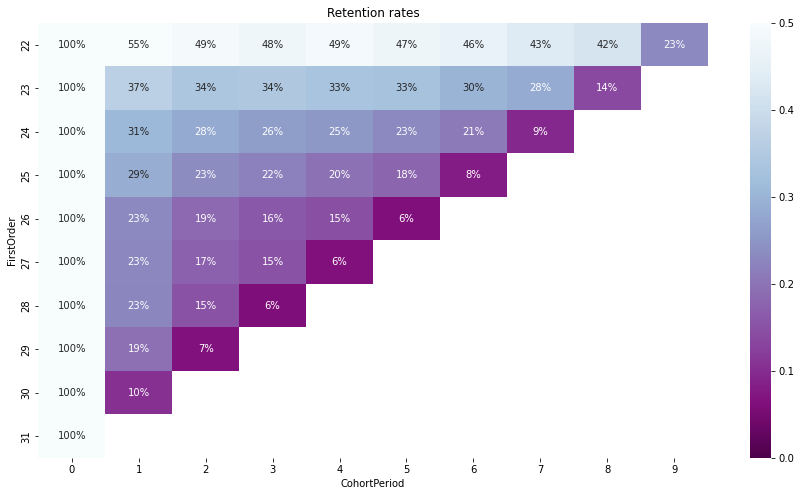

In [18]:
#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data=user_retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="BuPu_r")
plt.show()

# RFM Analysis

In [19]:
df = df[df['event_name'] == 'purchase_success']

In [20]:
#Data preparation steps

print('Min event_timestamp :',df.event_timestamp.dt.date.min(),'max event_timestamp:',
       df.event_timestamp.dt.date.max())

df.head(3)

Min event_timestamp : 2021-06-03 max event_timestamp: 2021-08-04


,user_no,session_id,event_timestamp,event_name,item_no,country,region,platform,item_name,image_name,...,category1_name,category2_code,category2_name,category3_code,category3_name,brand_no,brand_name,gender,OrderCycle,FirstOrder
40,l1wFRhb3av5rTWyYEofrIA==,cddf65caad5fe0da36ceaeaf6ecc7d45,2021-07-22 09:06:32.310004,purchase_success,5hZ+SkJkBUlB6WCwADoagg==,South Korea,Seoul,IOS,솔리드 카라 반팔 스웨터 (6color),6df3bfb40581b1ff90ce3a3c78082855,...,의류,243102100,상의,243102103,티셔츠,7593.0,OLZEN,F,29,22
49,l1wFRhb3av5rTWyYEofrIA==,cddf65caad5fe0da36ceaeaf6ecc7d45,2021-07-22 09:06:32.312005,purchase_success,IVX0H6CHgmJ89nKyPBXtSg==,South Korea,Seoul,IOS,그라데이션 반팔 카라 티셔츠_ZPZ2TT1503BL,140f86c27095d399bfe6797a5697c2f1,...,의류,243102100,상의,243102103,티셔츠,7593.0,OLZEN,F,29,22
52,Y5GM63HPuFwrRnvYhDu7sQ==,16e708ee91a1bd7beb297bf6bad1ddaa,2021-06-05 16:34:41.511016,purchase_success,4KwsZkXDulM0oQ2sTVSlYQ==,South Korea,Seoul,ANDROID,남성) 코튼 리넨 이지 쇼츠,ecb06f34b6d8c4c521221aebbcc0e934,...,의류,243104100,하의,243104101,바지,13901.0,TOPTEN,M,22,22


## Recency

In [21]:
# recency_df : 최근 우리가 분석하려는 마지막날짜기준으로 event_timestamp를 뺸 값.(마지막 구매일로부터 얼마나 흘렀는지.)
# 값이 작으면 최근에 구매한고객. 값이 커지면 구매한지 오래된 고객(다시안돌아올확률도높은고객).
# 주기가 짧을수록 가치있는 고객이라볼수있음.
recency_df = df.groupby('user_no')['event_timestamp'].max().reset_index()
recency_df.columns = ['user_no', 'LastPurchaseDate']
# snapshot_date = df['event_timestamp'].max() + dt.timedelta(days=1)
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x : (df['event_timestamp'].max() - x).days)
recency_df = recency_df.drop(columns=['LastPurchaseDate'])
recency_df.head()

,user_no,Recency
0,+++T9c17sr6wEYOy9UFv3w==,31
1,+++aQH5NnhiU/9qECKk3uQ==,43
2,++0bwiYVJ/TAsCpxI4UCuw==,7
3,++1HN9s1imztN8ftPCt3LA==,55
4,++2StXdzG0Bj/Kkb5EFcog==,35


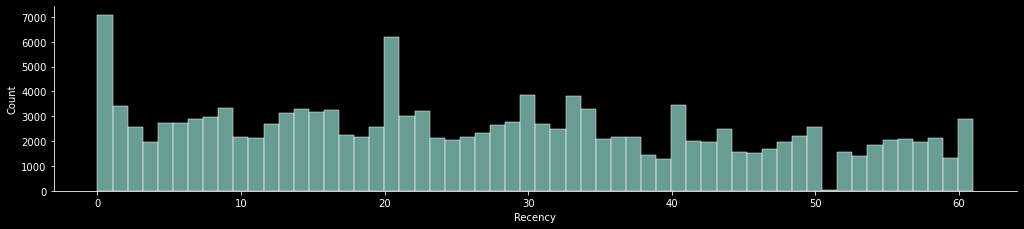

In [22]:
# Recency 분포 확인
plt.style.use(['dark_background'])

sns.displot(data = recency_df, x='Recency')
plt.gcf().set_size_inches(16.5, 3)

## Frequency

In [23]:
# user_no당 unique한 상품을 1개의 주문건으로 인식하여 얼마나 자주 구매하고 있는지를 파악
# 장바구니에 여러개 담겨있어도 그때에 구매는 1번 구매한것으로 인식.
# keep = 'first'를 하던 last를 하던 상관없음. 그때에 한번 구매했다는것만 알수있으면됨.
frequency_df = df.drop_duplicates(['user_no','session_id'],keep='first')
frequency_df = frequency_df.groupby('user_no')['session_id'].count().reset_index()
frequency_df.columns = ['user_no','Frequency']
frequency_df.head()

,user_no,Frequency
0,+++T9c17sr6wEYOy9UFv3w==,4
1,+++aQH5NnhiU/9qECKk3uQ==,2
2,++0bwiYVJ/TAsCpxI4UCuw==,1
3,++1HN9s1imztN8ftPCt3LA==,1
4,++2StXdzG0Bj/Kkb5EFcog==,1


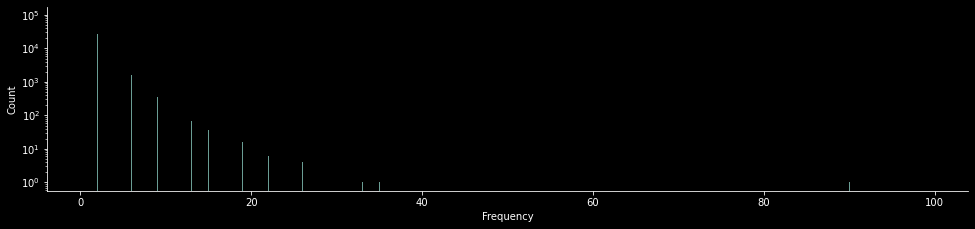

In [24]:
# Frequency 분포 확인
plt.style.use(['dark_background'])

sns.displot(data = frequency_df, x='Frequency')
plt.yscale('log')
plt.gcf().set_size_inches(16.5, 3)

## Monetary

In [25]:
monetary_df = df.groupby('user_no')['price'].sum().reset_index()
monetary_df.columns = ['user_no','Monetary']
monetary_df.head()

,user_no,Monetary
0,+++T9c17sr6wEYOy9UFv3w==,274500.0
1,+++aQH5NnhiU/9qECKk3uQ==,163000.0
2,++0bwiYVJ/TAsCpxI4UCuw==,88000.0
3,++1HN9s1imztN8ftPCt3LA==,16800.0
4,++2StXdzG0Bj/Kkb5EFcog==,25900.0


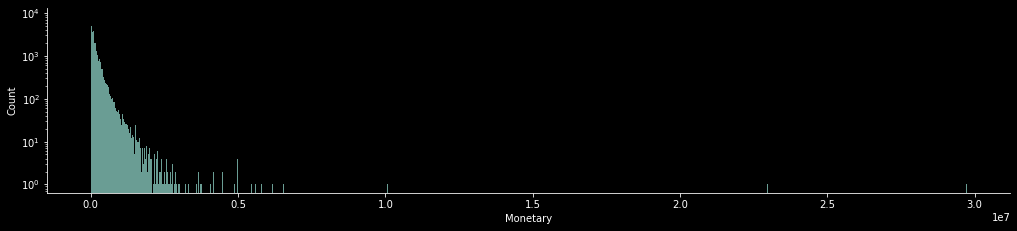

In [26]:
# Monetary 분포 확인
plt.style.use(['dark_background'])

sns.displot(data = monetary_df, x='Monetary')
plt.yscale('log')
plt.gcf().set_size_inches(16.5, 3)

## merge

In [27]:
rf = recency_df.merge(frequency_df,on=['user_no'])
rfm = rf.merge(monetary_df,on=['user_no'])
rfm.head()

,user_no,Recency,Frequency,Monetary
0,+++T9c17sr6wEYOy9UFv3w==,31,4,274500.0
1,+++aQH5NnhiU/9qECKk3uQ==,43,2,163000.0
2,++0bwiYVJ/TAsCpxI4UCuw==,7,1,88000.0
3,++1HN9s1imztN8ftPCt3LA==,55,1,16800.0
4,++2StXdzG0Bj/Kkb5EFcog==,35,1,25900.0


/Users/gg/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/gg/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/gg/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

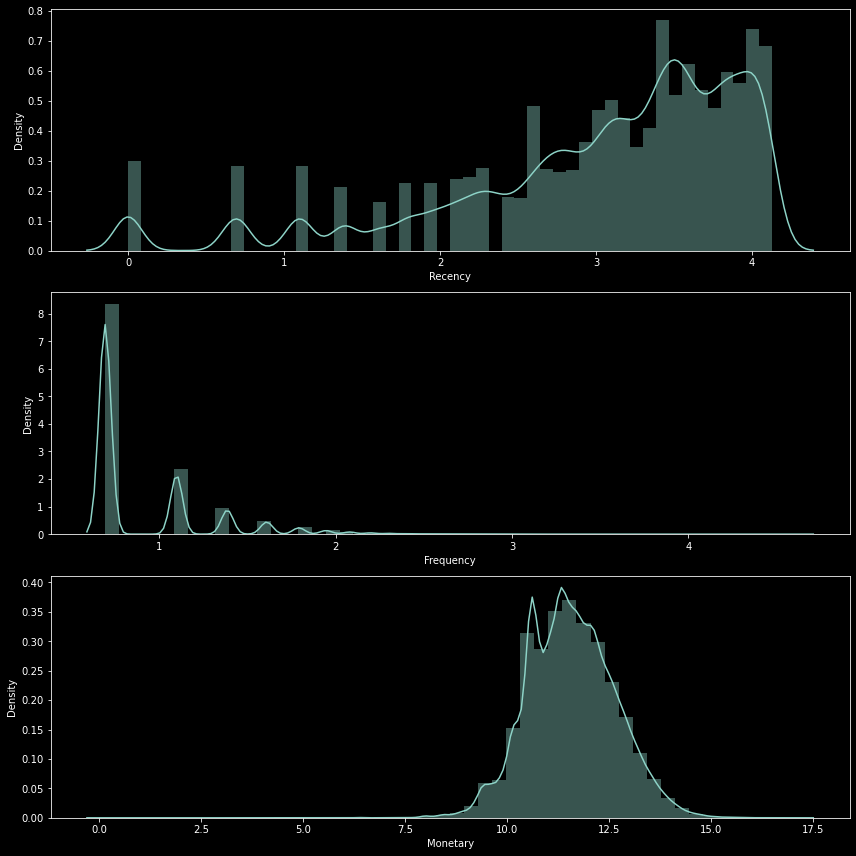

In [28]:
plt.style.use(['dark_background'])

kmeans = rfm.copy()
kmeans = kmeans.set_index('user_no')

kmeans_log = (kmeans+1).apply(np.log, axis = 1)

f,ax = plt.subplots(figsize=(12, 12))
plt.subplot(3, 1, 1); sns.distplot(kmeans_log.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(kmeans_log.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(kmeans_log.Monetary, label = 'Monetary')
plt.tight_layout()
plt.show()


## RFM

## data scaling

In [29]:
from sklearn.preprocessing import MinMaxScaler

rfm = rfm.set_index('user_no')

scaled = MinMaxScaler().fit_transform(rfm)
rfm_df = pd.DataFrame(data=scaled, columns=rfm.columns, index=rfm.index)

rfm_df['Recency'] = 1-rfm_df['Recency'] # 낮은고객일수록 가치가 높아서 역순취해서 높을수록 가치가 높게 해주기 위함.
rfm_df['Score'] = rfm_df['Recency'] + rfm_df['Frequency'] + rfm_df['Monetary']
rfm_df = rfm_df.reset_index()
rfm_df


,user_no,Recency,Frequency,Monetary,Score
0,+++T9c17sr6wEYOy9UFv3w==,0.491803,0.030612,0.009234,0.531650
1,+++aQH5NnhiU/9qECKk3uQ==,0.295082,0.010204,0.005483,0.310769
2,++0bwiYVJ/TAsCpxI4UCuw==,0.885246,0.000000,0.002960,0.888206
3,++1HN9s1imztN8ftPCt3LA==,0.098361,0.000000,0.000565,0.098926
4,++2StXdzG0Bj/Kkb5EFcog==,0.426230,0.000000,0.000871,0.427101
...,...,...,...,...,...
146899,zzrBh62TO71nt1GQm+jMjA==,0.885246,0.000000,0.006257,0.891503
146900,zzuJMnncH5Wrn/GUA7nqTg==,0.819672,0.000000,0.002187,0.821859
146901,zzwYai1YDr0JZQwaTqc0mQ==,0.508197,0.000000,0.001749,0.509946
146902,zzwxh/ZL9TPJOWZHLMvnDQ==,0.442623,0.000000,0.007044,0.449667


In [30]:
score = rfm_df[['user_no','Score']]
score = score.set_index('user_no')
scaled = (MinMaxScaler().fit_transform(score)) * 100
score_df = pd.DataFrame(data=scaled, columns=score.columns, index=score.index)
score_df = score_df.reset_index()

rfm_df['Score'] = score_df['Score']
rfm_df['Score'] = round(rfm_df['Score'],0)

rfm_df

,user_no,Recency,Frequency,Monetary,Score
0,+++T9c17sr6wEYOy9UFv3w==,0.491803,0.030612,0.009234,18.0
1,+++aQH5NnhiU/9qECKk3uQ==,0.295082,0.010204,0.005483,10.0
2,++0bwiYVJ/TAsCpxI4UCuw==,0.885246,0.000000,0.002960,30.0
3,++1HN9s1imztN8ftPCt3LA==,0.098361,0.000000,0.000565,3.0
4,++2StXdzG0Bj/Kkb5EFcog==,0.426230,0.000000,0.000871,14.0
...,...,...,...,...,...
146899,zzrBh62TO71nt1GQm+jMjA==,0.885246,0.000000,0.006257,30.0
146900,zzuJMnncH5Wrn/GUA7nqTg==,0.819672,0.000000,0.002187,27.0
146901,zzwYai1YDr0JZQwaTqc0mQ==,0.508197,0.000000,0.001749,17.0
146902,zzwxh/ZL9TPJOWZHLMvnDQ==,0.442623,0.000000,0.007044,15.0


## 점수 구간화

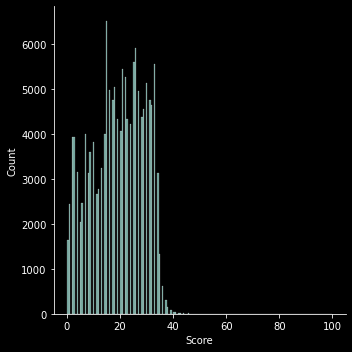

In [31]:
# score 구간 확인
sns.displot(rfm_df['Score'])
plt.show()

In [32]:
# ▶ 점수별로 고객의 등급을 부여
# 60점 이상 1
# 40~60점 2
# 20~40점 3
# 10~20점 4
# 0~10점 5

rfm_df['Grade'] = rfm_df['Score'].apply(lambda x : '1' if x>=60 else 
                                  ('2' if x>=40 else 
                                   ('3' if x>=20 else 
                                    ('4' if x>=10 else '5'))))
rfm_df.head(5)

,user_no,Recency,Frequency,Monetary,Score,Grade
0,+++T9c17sr6wEYOy9UFv3w==,0.491803,0.030612,0.009234,18.0,4
1,+++aQH5NnhiU/9qECKk3uQ==,0.295082,0.010204,0.005483,10.0,4
2,++0bwiYVJ/TAsCpxI4UCuw==,0.885246,0.000000,0.002960,30.0,3
3,++1HN9s1imztN8ftPCt3LA==,0.098361,0.000000,0.000565,3.0,5
4,++2StXdzG0Bj/Kkb5EFcog==,0.426230,0.000000,0.000871,14.0,4


In [33]:
# 원본에 고객의 등급 data merge
df = df.merge(rfm_df, left_on=['user_no'], right_on=['user_no'], how='left')
df.head()

,user_no,session_id,event_timestamp,event_name,item_no,country,region,platform,item_name,image_name,...,brand_no,brand_name,gender,OrderCycle,FirstOrder,Recency,Frequency,Monetary,Score,Grade
0,l1wFRhb3av5rTWyYEofrIA==,cddf65caad5fe0da36ceaeaf6ecc7d45,2021-07-22 09:06:32.310004,purchase_success,5hZ+SkJkBUlB6WCwADoagg==,South Korea,Seoul,IOS,솔리드 카라 반팔 스웨터 (6color),6df3bfb40581b1ff90ce3a3c78082855,...,7593.0,OLZEN,F,29,22,0.786885,0.000000,0.008612,27.0,3
1,l1wFRhb3av5rTWyYEofrIA==,cddf65caad5fe0da36ceaeaf6ecc7d45,2021-07-22 09:06:32.312005,purchase_success,IVX0H6CHgmJ89nKyPBXtSg==,South Korea,Seoul,IOS,그라데이션 반팔 카라 티셔츠_ZPZ2TT1503BL,140f86c27095d399bfe6797a5697c2f1,...,7593.0,OLZEN,F,29,22,0.786885,0.000000,0.008612,27.0,3
2,Y5GM63HPuFwrRnvYhDu7sQ==,16e708ee91a1bd7beb297bf6bad1ddaa,2021-06-05 16:34:41.511016,purchase_success,4KwsZkXDulM0oQ2sTVSlYQ==,South Korea,Seoul,ANDROID,남성) 코튼 리넨 이지 쇼츠,ecb06f34b6d8c4c521221aebbcc0e934,...,13901.0,TOPTEN,M,22,22,0.540984,0.040816,0.011128,20.0,3
3,Y5GM63HPuFwrRnvYhDu7sQ==,16e708ee91a1bd7beb297bf6bad1ddaa,2021-06-05 16:34:41.511017,purchase_success,4KwsZkXDulM0oQ2sTVSlYQ==,South Korea,Seoul,ANDROID,남성) 코튼 리넨 이지 쇼츠,ecb06f34b6d8c4c521221aebbcc0e934,...,13901.0,TOPTEN,M,22,22,0.540984,0.040816,0.011128,20.0,3
4,Y5GM63HPuFwrRnvYhDu7sQ==,62f88dca0928240cc90b285198b43f73,2021-06-10 20:26:17.230003,purchase_success,Mf87JOdySsyLCRGGz/yLIQ==,South Korea,Seoul,IOS,토앤토 제로비티 플립플랍 Stone Gray,76a8119271c45021975cb6edf9624a29,...,13639.0,TAW&TOE_이누,M,23,22,0.540984,0.040816,0.011128,20.0,3


## 주별 이용 고객 현황

In [34]:
cus_df = df.groupby('OrderCycle')['user_no'].nunique().reset_index()

Min event_timestamp : 2021-06-03 max event_timestamp: 2021-08-04


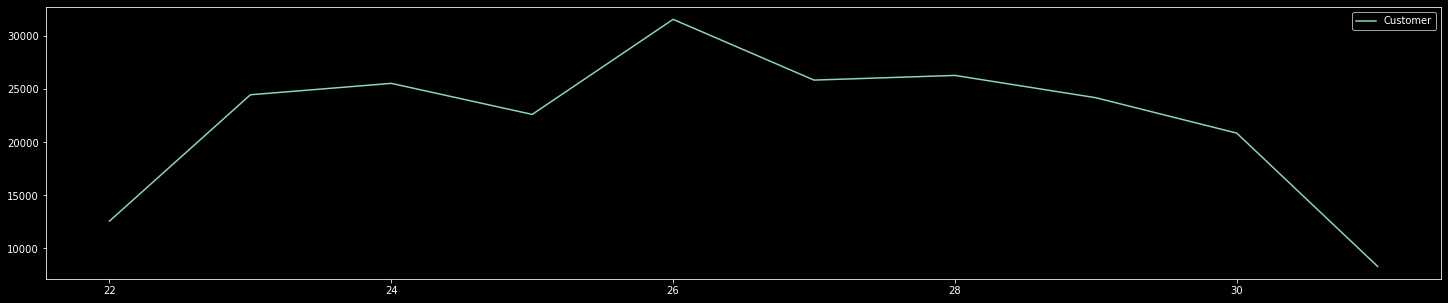

In [35]:
# 마지막에 그래프가 내려가있는이유는 8월4일 1주차정도밖에 데이터가 없기때문.
plt.plot(cus_df['OrderCycle'], cus_df['user_no'], label='Customer');
plt.legend();
plt.gcf().set_size_inches(25, 5)
print('Min event_timestamp :',df.event_timestamp.dt.date.min(),'max event_timestamp:',
       df.event_timestamp.dt.date.max())

## 주별 Grade 이용 비중

In [36]:
grade_df = df.groupby(['OrderCycle','Grade'])['user_no'].nunique().reset_index()

In [37]:
df_pivot = pd.pivot_table(grade_df,            # 피벗할 데이터프레임
                      index = 'OrderCycle',        # 행 위치에 들어갈 열
                      columns = 'Grade',       # 열 위치에 들어갈 열
                      values = 'user_no')   # 데이터로 사용할 열 

df_pivot.fillna(0, inplace=True)
df_pivot['total'] = df_pivot['1'] + df_pivot['2'] + df_pivot['3'] + df_pivot['4'] + df_pivot['5']


df_pivot.iloc[:,0] = (df_pivot.iloc[:,0] / df_pivot['total'])
df_pivot.iloc[:,1] = (df_pivot.iloc[:,1] / df_pivot['total'])
df_pivot.iloc[:,2] = (df_pivot.iloc[:,2] / df_pivot['total'])
df_pivot.iloc[:,3] = (df_pivot.iloc[:,3] / df_pivot['total'])
df_pivot.iloc[:,4] = (df_pivot.iloc[:,4] / df_pivot['total'])

df_pivot.drop(['total'], axis=1, inplace=True)
df_pivot

Grade,1,2,3,4,5
OrderCycle,,,,,
22,0.000159,0.005884,0.361800,0.121581,0.510576
23,0.000123,0.004371,0.350176,0.126256,0.519075
24,0.000117,0.004500,0.357241,0.151387,0.486755
25,0.000133,0.004905,0.366930,0.601387,0.026645
26,0.000095,0.003735,0.333555,0.662615,0.000000
27,0.000116,0.004562,0.619022,0.376300,0.000000
28,0.000114,0.004562,0.995324,0.000000,0.000000
29,0.000124,0.004669,0.995207,0.000000,0.000000
30,0.000144,0.005703,0.994154,0.000000,0.000000


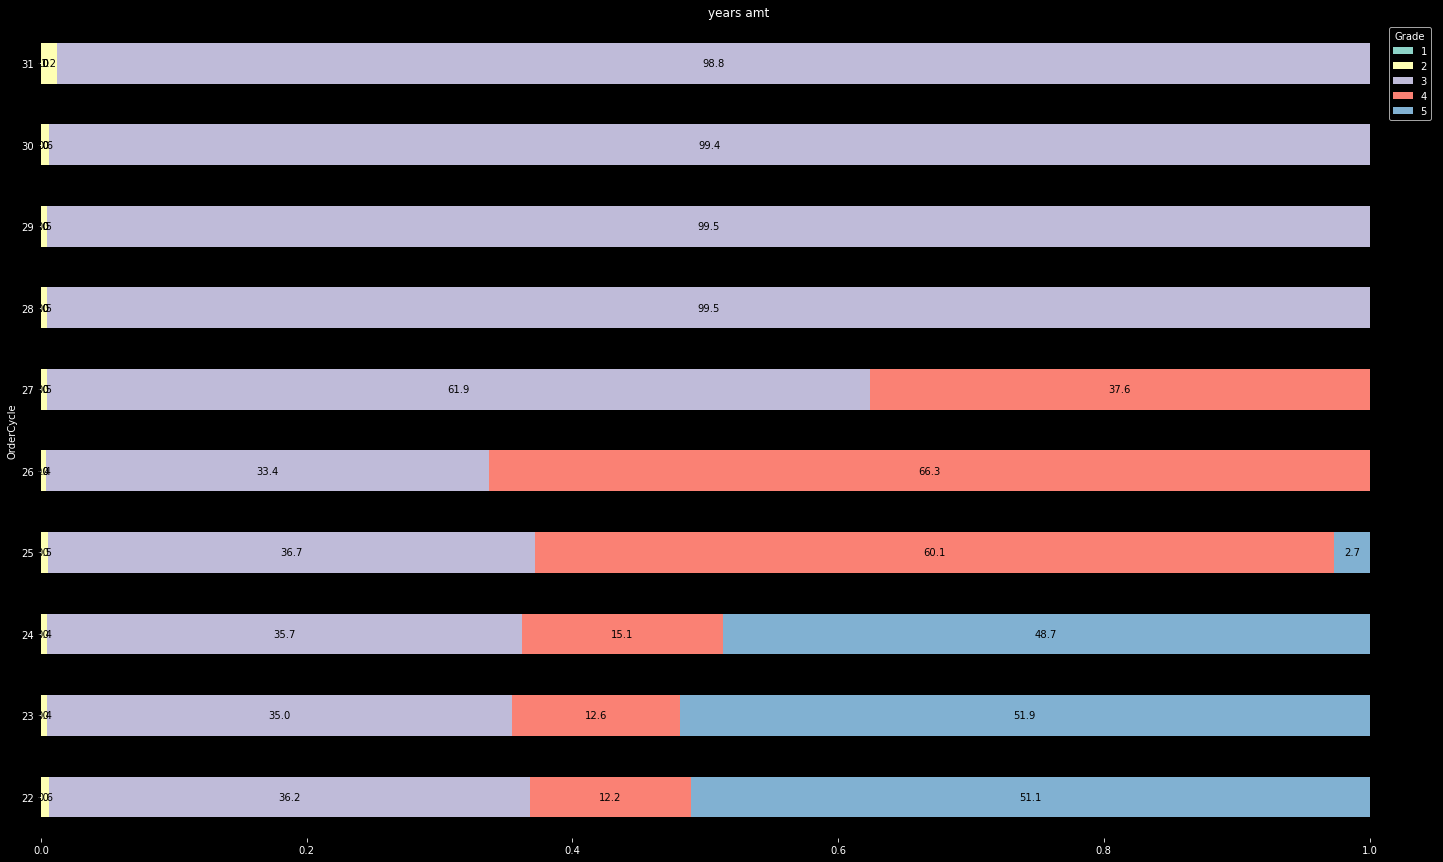

In [38]:
# 1번 vvip는 거의 없다시피하나, vip고객(2)은 어느정도 유지가 되고있고, 노말고객(3)의 증가율이 높은 것을 볼수있음.
import warnings
warnings.filterwarnings('ignore')
plt.style.use(['dark_background'])

ax = df_pivot.plot(kind='barh', stacked=True, title="years amt", rot=0);
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.1f"%(width*100), xy=(left+width/2, bottom+height/2), ha='center', va='center', color='black');

plt.box(False)
plt.gcf().set_size_inches(25, 15)
plt.show()